# Healthcare Case Studies Report
- Darshil Desai, Edwin Ramirez, Rashi Saxena

(D combined with rupdate) 5/1/19

<h1 id="tocheading">Table of Contents</h1>
<br>
<div id="toc">

<h2> test </h2>

</div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
// Run this to refresh /show table of contents if you've made any changes

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_classif, chi2, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,roc_auc_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import chi2_contingency
from scipy import stats

import seaborn as sns
import re

from stepwise_regression import stepwise_regression  # !pip install stepwise-regression
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.gofplots import ProbPlot

# Project Overview

In this project we dive deep into the depths of the healthcare dataset and explore insightful relationships between the different types of data provided and pursue building predictive models


We will be predicting: 
- Regression: Predict post_medical_cost
- Classifications - Logistic, KNN and NB: to predict pdc_80_flag

# Exploring the Dataset

Before we dive deeper into model building, we need to explore our dataset. [ADD MORE]


In [3]:
# Reading in the data file
data = pd.read_csv('projectTrain.csv')
data.head()

,pdc,num_ip_post,total_los_post,num_op_post,num_er_post,num_ndc_post,num_gpi6_post,adjust_total_30d_post,generic_rate_post,post_ip_flag,...,generic_cost,brand_cost,ratio_G_total_cost,numofgen_post,numofbrand_post,generic_cost_post,brand_cost_post,ratio_G_total_cost_post,pdc_80_flag,drug_class
0,0.333333,0,0,4,0,15,5,14.466667,0.101382,0,...,30.621563,2984.927229,0.010155,2,13,196.359216,3001.501507,0.061403,0,*ANTIDIABETICS*
1,0.866667,0,0,5,0,16,4,18.000000,0.888889,0,...,720.788173,0.000000,1.000000,14,2,671.755173,735.661568,0.477297,1,*ANTIDIABETICS*
2,0.938889,0,0,7,0,11,4,8.600000,1.000000,0,...,179.538533,0.000000,1.000000,11,0,171.446621,0.000000,1.000000,1,*ANTICOAGULANTS*
3,0.077778,1,12,40,0,5,5,2.033333,1.000000,1,...,105.816329,0.000000,1.000000,5,0,335.826436,0.000000,1.000000,0,*ANTICOAGULANTS*
4,0.444444,0,0,12,1,15,9,14.833333,0.528090,0,...,630.173638,3265.595950,0.161758,8,7,75.988845,2054.400835,0.035669,0,*ANTIDIABETICS*


In [4]:
# Taking a look at the data dimensions
print ('This dataset has {} records and {} features'.format(data.shape[0], data.shape[1]))

This dataset has 2000 records and 94 features


In [5]:
# Features in focus
print ('Predictor variable for the regression problem: post_medical_cost & for the classification problem: pdc_80_flag' )

Predictor variable for the regression problem: post_medical_cost & for the classification problem: pdc_80_flag


## Creating Datasets

In this section we will subset the dataframe and select the features we deem appropriate to further this analysis. Note that these features are not final and among these features there will be several that will not be selected for the machine learning models. In the "Feature Selection" section of this project, we will employ the use of various statistical techniques to determine the appropriateness of the same. 

In [6]:
def create_data(problem_type, data):
    """        
    Returns the continuous AND categorical datasets for either the categorical or continuous problem
    
    Parameters
    -------------
    : problem_type: enter either 'class' for classification or 'reg' for regression
    : data: the raw dataset provided to us    
    
    Returns
    ---------
    2 PROCESSED dataframes. First one being the continuous features and the other being categorical features. 
    
    Example:
    ----------
    - Data needed for classification
    >>> continuous_variables_for_classification_dataframe = create_data('class', data = data)[0]
    >>> categorical_variables_for_classification_dataframe = create_data('class', data = data)[1]
    
    - Data needed for regression
    >>> continuous_variables_for_regression_dataframe = create_data('reg', data = data)[0]
    >>> categorical_variables_for_regression_dataframe = create_data('reg', data = data)[1]        
    
    You can then combine them into one training data and use it accordingly. 
    >>> training_data_regression = pd.concat([continuous_variables_for_regression_dataframe, categorical_variables_for_regression_dataframe], 1)
    """    
        
    #-----------------------------------

    if problem_type == 'class':
        """Subsetting the dataset to account for diabetic patients only for classification"""
        data1 = data[data['drug_class'].str.contains('ANTIDIABETIC')]
    
    if problem_type == 'reg':
        """Subsetting the dataset to account for diabetic patients only for classification"""
        data1 = data                

    #-----------------------------------
    """Creating the Continous variables"""
    first_cont = data1.iloc[:,0:19]
    other_cont = data1.iloc[:,62:92]

    # Combine the get all the continuous variables
    cont_features = pd.concat([first_cont,other_cont ],axis=1)

    # Selecting all columns that dont have the word "post" or total in it. Except of course post_total_cost
    cont_features = cont_features[cont_features.columns[[not i for i in [bool(re.search('post|total', x)) for x in cont_features.columns]]]]

    #-----------------------------------
    """Categorical variables"""

    # Subsetting the different types of categorical columns
    all_diseases = data1.iloc[:,26:61]  # Diseases
    othercats = data1.iloc[:,19:22]  # Other categories like region, Sex, PCI etc
    cat_features = pd.concat([all_diseases,othercats ],axis=1)  # Combine all categorical variables into one dataframe

    cat_features1 = cat_features  # Rereate for safety

    # Initialize an empty list to append select all columns that will be one-hot-encoded
    u_cols = []

        # --------------------------------------

    # For each column check if number of unique values > 2, if so one-hotcode them
    for x in cat_features1.columns:

        # Chrck if number of unque values in column is greater than 2
        if (len(cat_features1[x].value_counts().index)) >2:  
            # print (x, len(cat_features1[x].value_counts().index))

            # Append to empty list if num of unique values in list is > 2
            u_cols.append(x)

            # Create dummy variables for the x column
            dummy = pd.get_dummies(pd.get_dummies(cat_features1[x], prefix = '{}'.format(x)))

            # Append dummy variables to the main  
            cat_features1 = pd.concat([cat_features1, dummy], axis=1)

    # Keep only the dummy variables, remove the original variable
    use_cols = [x for x in cat_features1.columns if x not in u_cols ]

    # Finally subset the categorical variables and use only dummy variables
    cat_features1 = cat_features1[use_cols]

    # --------------------------------------
    return cont_features, cat_features1            
    # --------------------------------------
                

###  (A) Classification Dataset

In this section we will employ the use of manual feature selection to select relevant features that are required for predicting the pdc_80_flag.

- **a. Antidiabetics Only:** The classification problem requires a model trained only on Antidiabetic patients. Therefore, we will subset the dataset accordingly


- **b. Selecting continuous features:** Although there are no explicit requirements for selecting the relevant continuous variables, it is important to note that because we are predicting the proportion of days covered (follow up) , it would be more appropriate to limit our continuous features to the pre-index range


- **c. Selecting categorical features:** We will begin my selecting all the categorical features that are present. Furthermore, there lies a need to transform categorical features into dummy variables in the event that a categorical variable has more than 2 values

In [7]:
# Creating our dataset for the classification problem
class_cont_vars = create_data('class', data = data)[0]
class_categorical_vars = create_data('class', data = data)[1]

In [8]:
class_cont_vars.head(2)

,pdc,pdc_cat,idx_copay,pre_er_cost,pre_rx_cost,pre_op_cost,pre_medical_cost,num_ip,num_op,num_er,...,pre_ip_flag,pre_er_flag,log_pre_ip_cost,log_pre_er_cost,log_pre_op_cost,log_pre_rx_cost,numofgen,numofbrand,generic_cost,brand_cost
0,0.333333,3,40.474500,0.0,3015.548793,1626.271037,1626.271037,0,27,0,...,0,0,-4.60517,-4.60517,7.394045,8.011537,2,13,30.621563,2984.927229
1,0.866667,1,4.060471,0.0,720.788173,479.349400,479.349400,0,3,0,...,0,0,-4.60517,-4.60517,6.172430,6.580345,17,0,720.788173,0.000000


In [9]:
class_categorical_vars.head(2)

,ALCOHOL_DRUG,ASTHMA,CARDIAC_ARRYTHMIA,CARDIAC_VALVULAR,CEREBROVASCULAR,CHRONIC_KIDNEY,CHRONIC_PAIN_FIBRO,CHF,COPD,DEMENTIA,...,pre_CCI_7,pre_CCI_8,pre_CCI_10,age_grpN_2,age_grpN_3,age_grpN_4,regionN_1,regionN_2,regionN_3,regionN_4
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [10]:
class_cont_vars.columns

Index(['pdc', 'pdc_cat', 'idx_copay', 'pre_er_cost', 'pre_rx_cost',
       'pre_op_cost', 'pre_medical_cost', 'num_ip', 'num_op', 'num_er',
       'num_ndc', 'num_gpi6', 'generic_rate', 'pre_ip_flag', 'pre_er_flag',
       'log_pre_ip_cost', 'log_pre_er_cost', 'log_pre_op_cost',
       'log_pre_rx_cost', 'numofgen', 'numofbrand', 'generic_cost',
       'brand_cost'],
      dtype='object')

###  (B) Regression Dataset

In this section we will employ the use of manual feature selection to select relevant features that are required for predicting the pdc_80_flag.

- **a. All patients:** The classification problem required a model trained only on Antidiabetic patients. For the purpose of predicting the post_total_cost we will employ the use of 


- **b. Selecting continuous features:** It is important to note that because we are predicting the proportion of days covered (follow up) , it would be more appropriate to limit our continuous features to the pre-index range


- **c. Selecting categorical features:** We will begin my selecting all the categorical features that are present. Furthermore, there lies a need to transform categorical features into dummy variables in the event that a categorical variable has more than 2 values

In [11]:
# Creating our dataset for the regression problem
reg_cont_vars = create_data('reg', data = data)[0]
reg_categorical_vars = create_data('reg', data = data)[1]

In [12]:
reg_cont_vars.head(2)

,pdc,pdc_cat,idx_copay,pre_er_cost,pre_rx_cost,pre_op_cost,pre_medical_cost,num_ip,num_op,num_er,...,pre_ip_flag,pre_er_flag,log_pre_ip_cost,log_pre_er_cost,log_pre_op_cost,log_pre_rx_cost,numofgen,numofbrand,generic_cost,brand_cost
0,0.333333,3,40.474500,0.0,3015.548793,1626.271037,1626.271037,0,27,0,...,0,0,-4.60517,-4.60517,7.394045,8.011537,2,13,30.621563,2984.927229
1,0.866667,1,4.060471,0.0,720.788173,479.349400,479.349400,0,3,0,...,0,0,-4.60517,-4.60517,6.172430,6.580345,17,0,720.788173,0.000000


In [13]:
reg_categorical_vars.head(2)

,ALCOHOL_DRUG,ASTHMA,CARDIAC_ARRYTHMIA,CARDIAC_VALVULAR,CEREBROVASCULAR,CHRONIC_KIDNEY,CHRONIC_PAIN_FIBRO,CHF,COPD,DEMENTIA,...,pre_CCI_8,pre_CCI_9,pre_CCI_10,age_grpN_2,age_grpN_3,age_grpN_4,regionN_1,regionN_2,regionN_3,regionN_4
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


### (C) Visual Exploratory Data Exploration

Now that we have our datsets, lets examine the structure and distribution of the different types of data within these datasets

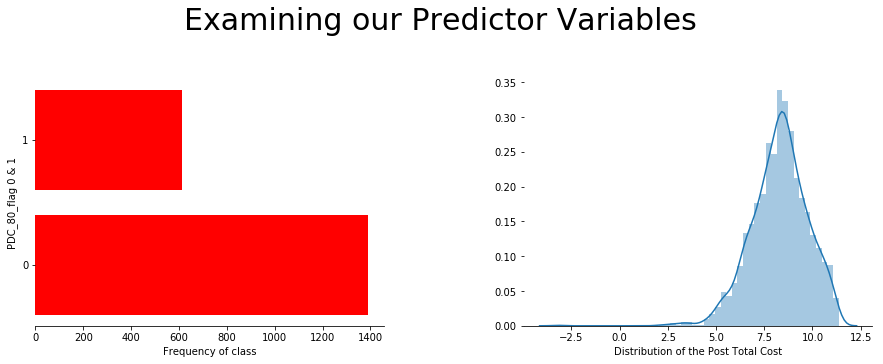

In [17]:
# Taking a look at our predictor variables

plt.figure(figsize=(15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
plt.suptitle('Examining our Predictor Variables', fontsize=30)

#-------------------------------------------

# Plotting the predictor variable to convey class balance or imbalance
plt.subplot(2,2,1)
a = pd.DataFrame(data.groupby(data.pdc_80_flag)['pdc_80_flag'].count())
plt.barh(list(a.index),a.pdc_80_flag, color = 'red')
plt.xlabel('Frequency of class')
plt.ylabel('PDC_80_flag 0 & 1')
plt.yticks([0,1])

#-------------------------------------------
# Plotting the predictor variable to convey class balance or imbalance
plt.subplot(2,2,2)
sns.distplot((np.log(data['post_total_cost'])), label="Actual High")  # Log transforming the post_total_cost 
plt.xlabel('Distribution of the Post Total Cost')
sns.despine(left=True)

Our visual analysis yields the following:

- **Pdc_80_flag:** Here we observe a class imbalanced dataset wherein proportion of DIABETIC patients that have a pdc > 0.8 and consequentially pdc_80_flag = 1 is a lot lower than those with pdc_80_flag as 0.


- **Distribution of Post Total Cost:** The distribution of the Post Total Cost metric, which we will use as a predictor variable in the regression problem, is left skewed and therefore warrants some type of data transformation or outlier removal. We will explore these possibilities later on in the report. 

**Next we will take a closer look at four of our categorical variables relationship with our predictor variable, total medical cost.**

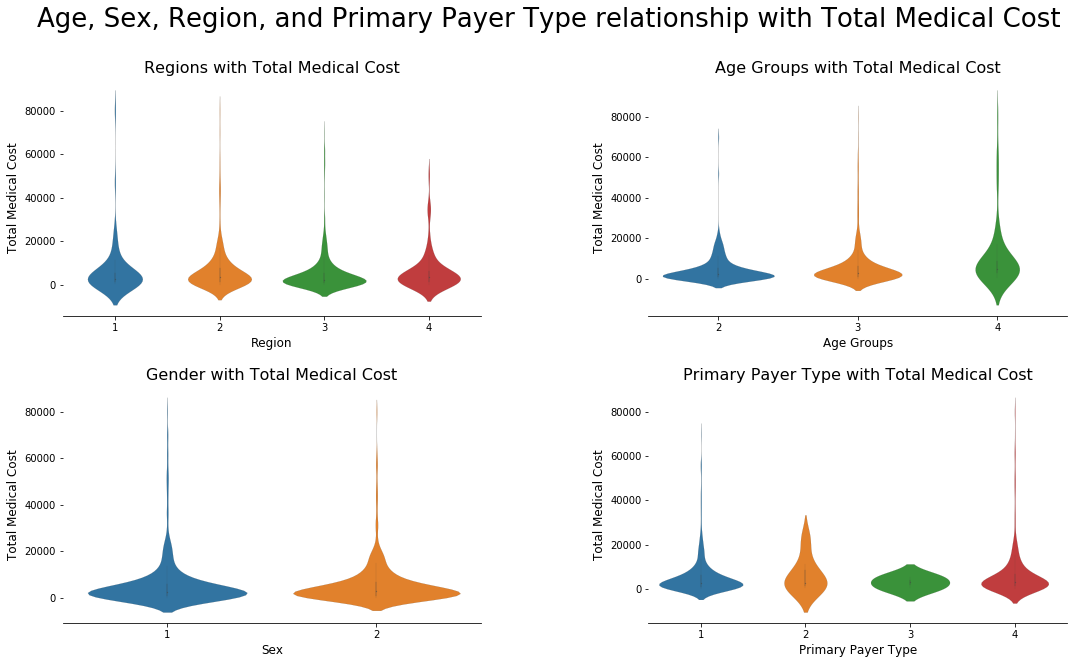

In [15]:
#Taking a look at Age, Sex, Region, and Primary Payer Type relationship with Total Medical Cost

data1 = data[data['drug_class'].str.contains('ANTIDIABETICS')]

plt.figure(figsize=(18,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.3)

plt.suptitle('Age, Sex, Region, and Primary Payer Type relationship with Total Medical Cost', fontsize=26)

#-------------------------------------------
plt.subplot(2,2,1)

sns.violinplot(x=data1.regionN, y= data['post_total_cost'], linewidth=0.1)
plt.xlabel('Region',fontsize = 12)
plt.ylabel('Total Medical Cost',fontsize = 12)
plt.title('Regions with Total Medical Cost',fontsize = 16)

#-------------------------------------------
plt.subplot(2,2,2)


sns.violinplot(x=data1.age_grpN, y=data['post_total_cost'], linewidth=0.1)
plt.xlabel('Age Groups',fontsize = 12)
plt.ylabel('Total Medical Cost',fontsize = 12)
plt.title('Age Groups with Total Medical Cost',fontsize = 16)
#-------------------------------------------
plt.subplot(2,2,3)


sns.violinplot(x=data1.sexN, y=data['post_total_cost'], linewidth=0.1)
plt.xlabel('Sex',fontsize = 12)
plt.ylabel('Total Medical Cost',fontsize = 12)
plt.title('Gender with Total Medical Cost',fontsize = 16)

#--------------------------------------------

plt.subplot(2,2,4)


sns.violinplot(x=data1.idx_paytypN, y=data['post_total_cost'], linewidth=0.1)
plt.xlabel('Primary Payer Type',fontsize = 12)
plt.ylabel('Total Medical Cost',fontsize = 12)
plt.title('Primary Payer Type with Total Medical Cost',fontsize = 16) 
sns.despine(left=True); 

Through this visual analysis, we understand the following: 

- **Region-** 1(Northeast), 2(Midwest), 3(South), and 4(West). We can see that the distributions are pretty similar through the regions. We also notice that there are a lot of outliers in regions in all the regions. This may be something we are interested in checking further and eliminating from our data for our models. We can also see that the average total medical cost is different in different regions, showing us that this may be a good variable to use when predicting the total medical cost.


- **Age Groups-** 1(0 - 18 years), 2(19 - 44 years), 3(45 - 64 years), 4(65+ years). We notice a few things in this plot- 1) that there is no data present for the age group from 0-18 years, 2) there are a lot of outliers present in each age group, 3) the average total medical cost is pretty similar for age group 2,3, but different for age group 4. Groups 2 and 3 have a similar distribution vs group 4 is a bit different than the other groups.


- **Gender-** 1(Male), 2(Female) - We see that there are a lot of outliers in in both Male and Female groups. We can also see that the average total medical cost seems very similar between the both groups and that both groups also have a similar distribution.


- **Primary Payer Type-** 1(Commercial), 2(Medicaid), 3(Medicare), 4(Self-Insured). We can there are a lot of outliers in Type 1 and Type 4. We can also observe the difference in the average total medical cost in the different primary payer types along with huge different in the distributions for the different levels of primary payer type through the total medical cost.


**Next:** We take a closer look at the distribution of some of our continous variables.

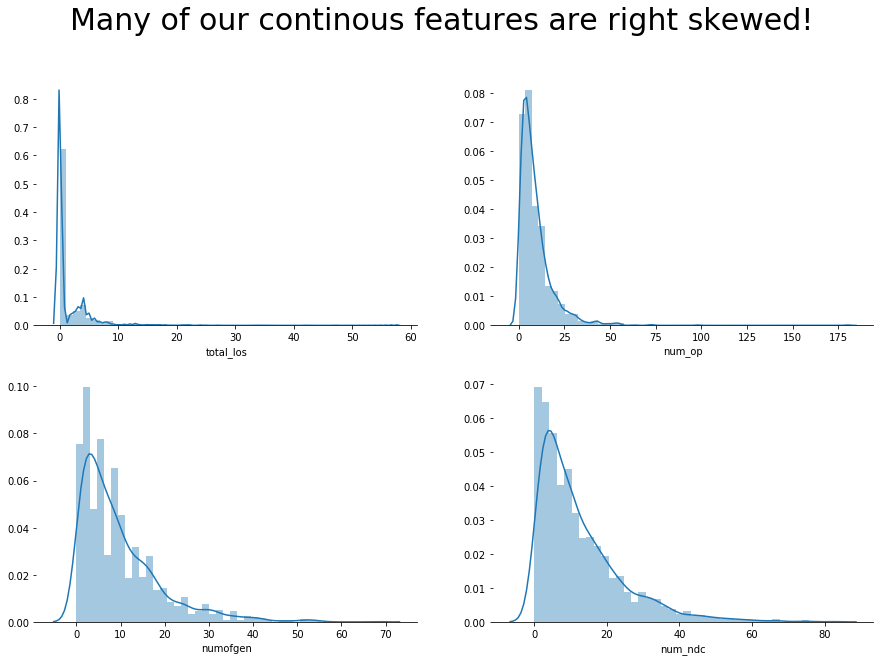

''

In [18]:
plt.figure(figsize=(15,10))
plt.suptitle('Many of our continous features are right skewed!', fontsize=30)

#-------------------------------------------
plt.subplot(2,2,1)
plot_high = sns.distplot(data.total_los)

#-------------------------------------------
plt.subplot(2,2,2)
plot_low = sns.distplot(data.num_op)

#-------------------------------------------
plt.subplot(2,2,3)
plot_mel = sns.distplot(data.numofgen)

#--------------------------------------------
plt.subplot(2,2,4)
plot_rum = sns.distplot(data.num_ndc)
sns.despine(left=True)
plt.show() 
;

We are comparing the distributions for a few our continuous variables that we think will have a strong relationship with both our predictor variables, pdc_80_flag and post_total_cost. We can see that all four of the continuous features are right skewed. 


To explain further: 
- total_los - This variable is number of total inpatient days, pre-index. 
- num_op - This variable is the number of total outpatient visits, pre-index. 
- numofgen - This variable is the number of gGeneric scripts filled, pre-index. 
- num_ndc - This variable is the number of total number of prescriptions

# Regression - Method 1

In this section we will explore one of many different ways in which to apply feature selection and model fitting methods. Because a machine learning pipeline can involve the trial and error of ensembles of methods, we will try and come up with different ways to go about finding the best solution to predict the best solution.

## Feature Selection Using Collinearity Tests

In this section we will employ the use of a correlation matrix to determine the following: 

**- (i.) Multicollinearity:** Determine whether the continuous independent variables, which we will use to predict both the **post_total_cost** in as a regression problem, are independent of one another. Given the high dimensionality of our dataset, it is completely plausible for features to correlate with one another and moving forward without fixing this phenomenon will render the predictive model inaccurate and irrelevant.

**- (ii.) Correlation between independent variables and the predictor variable** We will determine whether there exists any significant collinearity between the feature set and the dependant variable (post_total_cost) we are trying to predict. In simple words, this allows us to answer to confirm that there indeed lies some type of "relationship" between what we are trying to predict and what we are using to predict. 

**- (iii.) Comparative T-Test:** In order to find the categorical variables that have would be valuable factors for us to use in our regression model, that is to predict the total medical costs, we will employ the use of comparative T-Tests to compare the the median post total cost for patients that have a disease(1) differs from the median total cost for patients that do not have a disease(0) for different variables. We will start with some simple boxplots to examine these differences, if any, visually. 

###  Multicollinearity

In order to observe multi-colinearity we need to take into account the **post_total_cost** variable. Since we only have the continuous and categorical variables for the regression problem, there lies a need to combine this feature set with the **post_total_cost** from the raw dataset (after correctly indexing ofcourse)

In [19]:
# Creating a dataset to measure multi-collinearity between the continuous variables in the regression feature set
#.... vs the post_total_cost variable
reg_data_multicolin =  pd.concat([reg_cont_vars, pd.DataFrame(data['post_total_cost'])],1)

reg_data_multicolin.post_total_cost = np.log(reg_data_multicolin.post_total_cost)

In [20]:
reg_data_multicolin.columns

Index(['pdc', 'pdc_cat', 'idx_copay', 'pre_er_cost', 'pre_rx_cost',
       'pre_op_cost', 'pre_medical_cost', 'num_ip', 'num_op', 'num_er',
       'num_ndc', 'num_gpi6', 'generic_rate', 'pre_ip_flag', 'pre_er_flag',
       'log_pre_ip_cost', 'log_pre_er_cost', 'log_pre_op_cost',
       'log_pre_rx_cost', 'numofgen', 'numofbrand', 'generic_cost',
       'brand_cost', 'post_total_cost'],
      dtype='object')

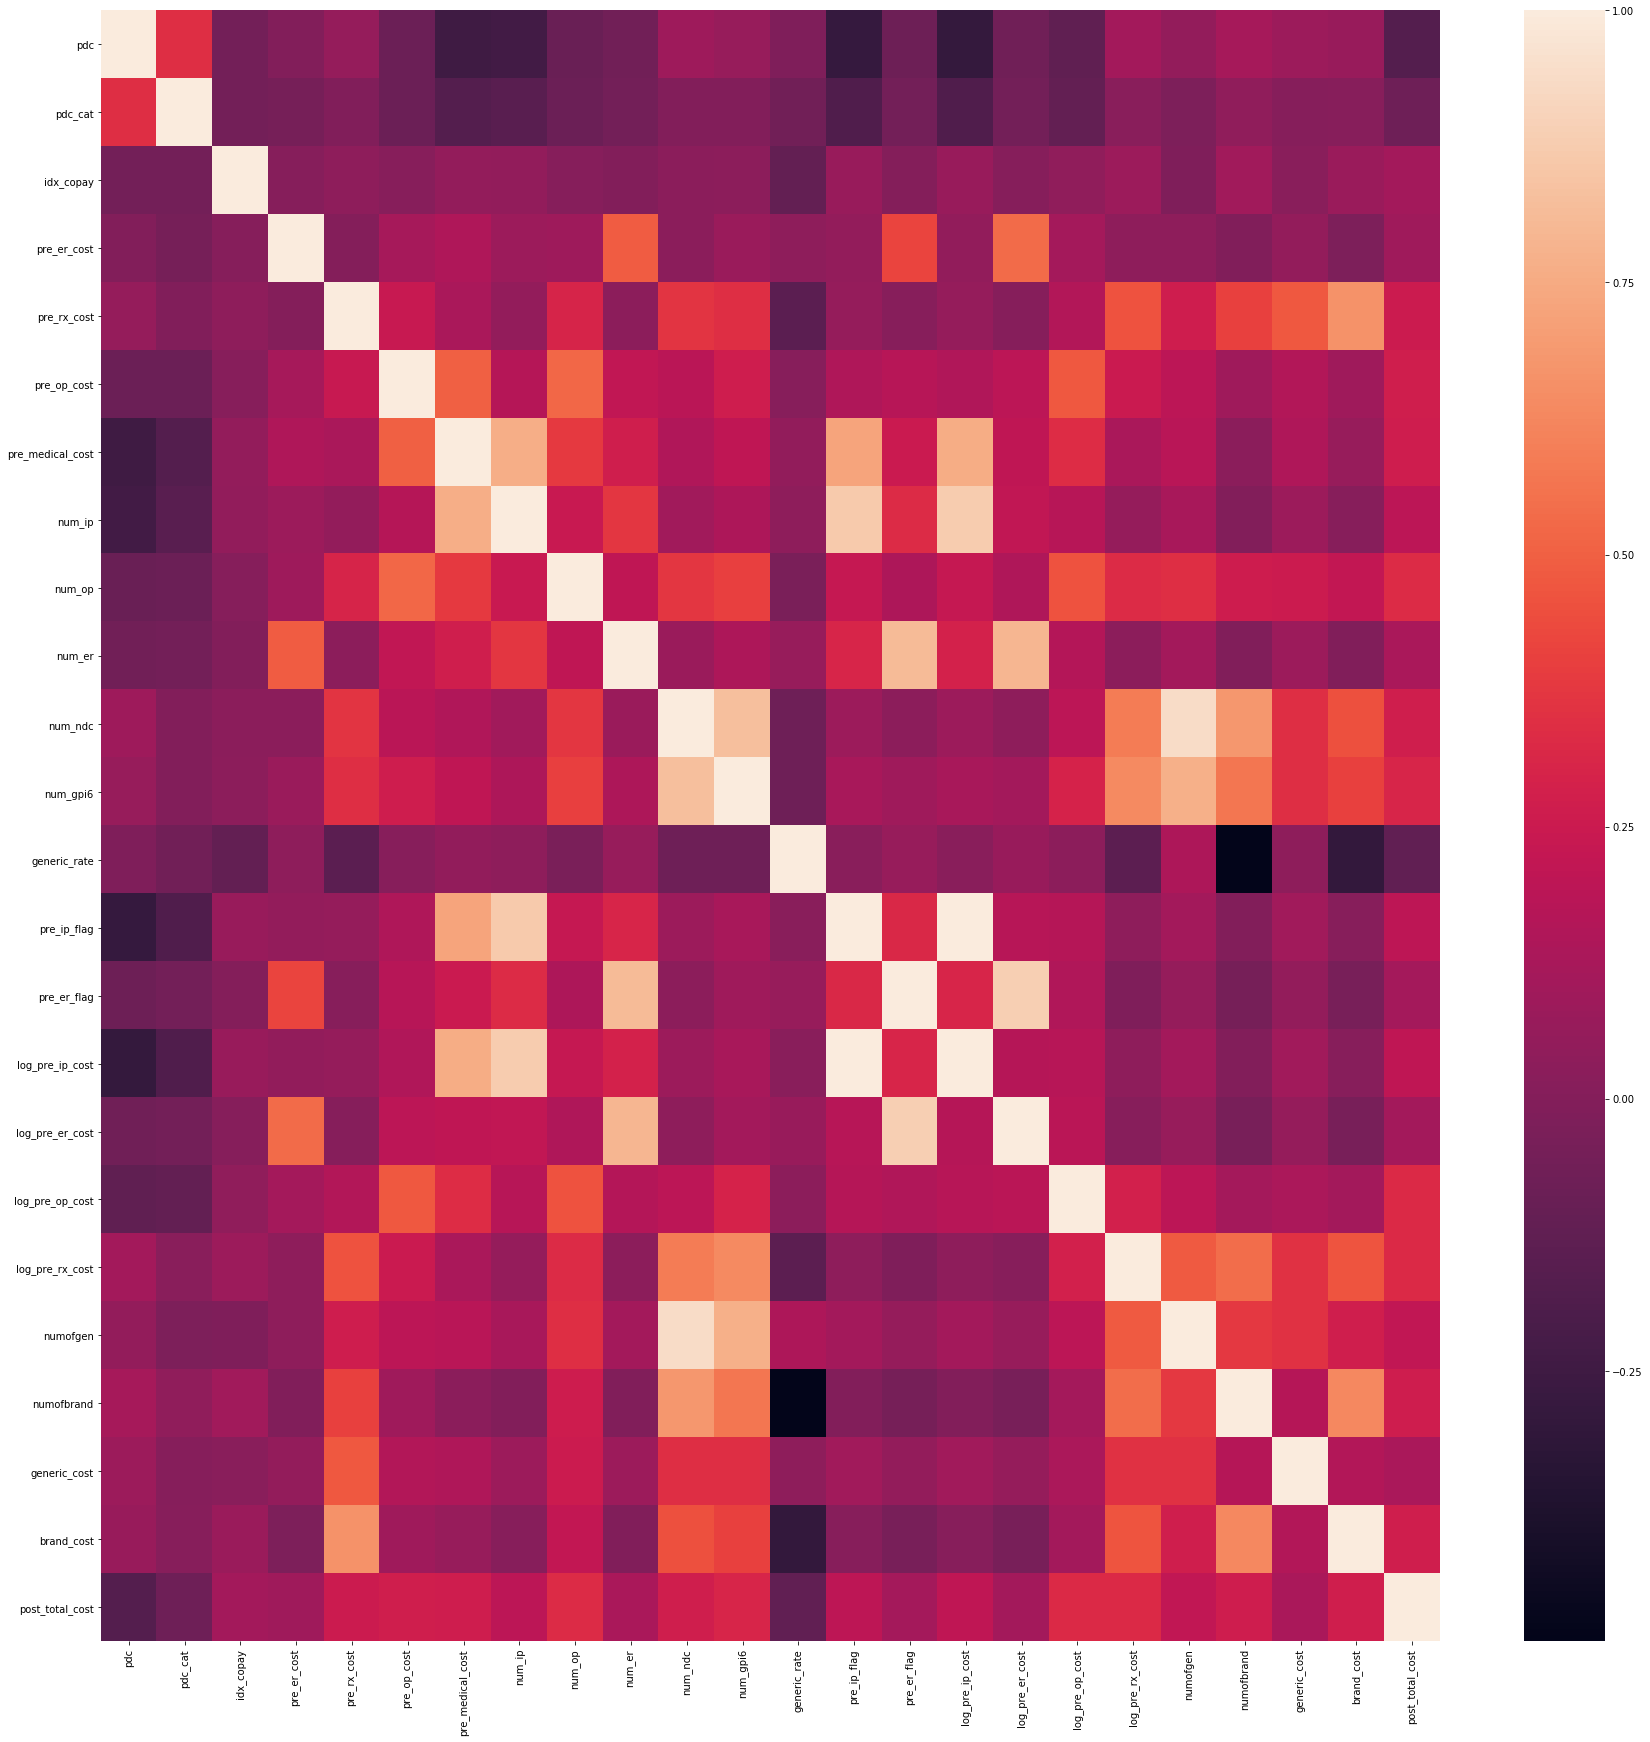

In [21]:
plt.figure(figsize=(30,30))
corr = reg_data_multicolin.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values) ;

**Next,** lets observe the above phenomenon numerically. Given below are the correlation coefficient values allow us to see how well numerical values correlate with one another. Recall that a good set of features are independent of one another

In [22]:
cor_matrix = reg_data_multicolin.corr()
cor_matrix.head(2)

,pdc,pdc_cat,idx_copay,pre_er_cost,pre_rx_cost,pre_op_cost,pre_medical_cost,num_ip,num_op,num_er,...,pre_er_flag,log_pre_ip_cost,log_pre_er_cost,log_pre_op_cost,log_pre_rx_cost,numofgen,numofbrand,generic_cost,brand_cost,post_total_cost
pdc,1.000000,0.341591,-0.058619,-0.006364,0.058645,-0.087541,-0.248723,-0.235985,-0.090750,-0.065161,...,-0.077712,-0.290646,-0.066916,-0.128328,0.104936,0.053872,0.116396,0.082020,0.070601,-0.169613
pdc_cat,0.341591,1.000000,-0.056841,-0.046401,-0.007951,-0.083604,-0.166922,-0.151466,-0.085418,-0.056625,...,-0.056358,-0.186000,-0.053942,-0.113994,0.019176,-0.023211,0.043687,0.010557,0.012129,-0.076850


In [23]:
"""This section drops continous variable that are highly correlated"""

# Upper triangle of correlation matrix
upper = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
upper.head(5)

,pdc,pdc_cat,idx_copay,pre_er_cost,pre_rx_cost,pre_op_cost,pre_medical_cost,num_ip,num_op,num_er,...,pre_er_flag,log_pre_ip_cost,log_pre_er_cost,log_pre_op_cost,log_pre_rx_cost,numofgen,numofbrand,generic_cost,brand_cost,post_total_cost
pdc,NaN,0.341591,-0.058619,-0.006364,0.058645,-0.087541,-0.248723,-0.235985,-0.090750,-0.065161,...,-0.077712,-0.290646,-0.066916,-0.128328,0.104936,0.053872,0.116396,0.082020,0.070601,-0.169613
pdc_cat,NaN,NaN,-0.056841,-0.046401,-0.007951,-0.083604,-0.166922,-0.151466,-0.085418,-0.056625,...,-0.056358,-0.186000,-0.053942,-0.113994,0.019176,-0.023211,0.043687,0.010557,0.012129,-0.076850
idx_copay,NaN,NaN,NaN,0.010053,0.038715,0.013279,0.053849,0.051249,0.008421,-0.002955,...,0.004703,0.070987,0.009803,0.044617,0.083538,-0.014657,0.100952,0.019877,0.076131,0.106989
pre_er_cost,NaN,NaN,NaN,NaN,0.001647,0.118528,0.145867,0.085313,0.089443,0.486773,...,0.419852,0.049058,0.534753,0.110547,0.037106,0.038104,-0.008949,0.051707,-0.018656,0.095110
pre_rx_cost,NaN,NaN,NaN,NaN,NaN,0.235396,0.130729,0.054448,0.301619,0.032082,...,0.012838,0.061715,0.009556,0.158766,0.457711,0.265368,0.403704,0.476390,0.660848,0.253092


In [24]:
# Dropping feature columns with correlation greater than selected inter - correlation strengh
to_drop = [column for column in upper.columns if any(upper[column]> 0.85) if column != 'post_total_cost' ]
to_drop

['pre_ip_flag', 'log_pre_ip_cost', 'log_pre_er_cost', 'numofgen']

In [25]:
# Selecting all features that do are NOT highly correlated
cont_variable_columns = [x for x in reg_data_multicolin.columns if x not in to_drop]

In [26]:
# Dataframe consisting of continous features ready to be used into our analysis
cont_features_uncorrelated =  reg_data_multicolin[cont_variable_columns]

In [27]:
# Finally these are the uncorrelated features to use
cont_features_uncorrelated.head(2)

,pdc,pdc_cat,idx_copay,pre_er_cost,pre_rx_cost,pre_op_cost,pre_medical_cost,num_ip,num_op,num_er,num_ndc,num_gpi6,generic_rate,pre_er_flag,log_pre_op_cost,log_pre_rx_cost,numofbrand,generic_cost,brand_cost,post_total_cost
0,0.333333,3,40.474500,0.0,3015.548793,1626.271037,1626.271037,0,27,0,15,6,0.082353,0,7.394045,8.011537,13,30.621563,2984.927229,8.175991
1,0.866667,1,4.060471,0.0,720.788173,479.349400,479.349400,0,3,0,17,4,1.000000,0,6.172430,6.580345,0,720.788173,0.000000,7.723045


### Collinearity with the Regression Predictor Variable

- In this section we will emplou tests to determine if the features are indeed correlated with what we need to predict, ie: the post total cost. Recall that unlike multicolinearity, here we want the correlation coefficient between any given continuous feature and the predictor variable to be high. Therefore suggesting that we do have relevant features to use in the model

In [28]:
# Correlation matrix between continous features only
cor_matrix_cont_features = cont_features_uncorrelated.corr()
cor_matrix_cont_features.head(2)

,pdc,pdc_cat,idx_copay,pre_er_cost,pre_rx_cost,pre_op_cost,pre_medical_cost,num_ip,num_op,num_er,num_ndc,num_gpi6,generic_rate,pre_er_flag,log_pre_op_cost,log_pre_rx_cost,numofbrand,generic_cost,brand_cost,post_total_cost
pdc,1.000000,0.341591,-0.058619,-0.006364,0.058645,-0.087541,-0.248723,-0.235985,-0.090750,-0.065161,0.087083,0.067182,-0.017797,-0.077712,-0.128328,0.104936,0.116396,0.082020,0.070601,-0.169613
pdc_cat,0.341591,1.000000,-0.056841,-0.046401,-0.007951,-0.083604,-0.166922,-0.151466,-0.085418,-0.056625,-0.002480,-0.005095,-0.061001,-0.056358,-0.113994,0.019176,0.043687,0.010557,0.012129,-0.076850


In [29]:
# Selecting the correlation strength as strength of associativity
corr_strength = 0.5

pd.set_option('display.max_rows', 100)
a = cor_matrix_cont_features['post_total_cost'] >= corr_strength
b = cor_matrix_cont_features['post_total_cost'][a]
names = [x for x in b.index if x != 'post_total_cost'] # all 
names

[]

In [30]:
# Get the names of all columns to finally use for regression
list_len = len(names)

for i in range(list_len):
    for j in range(i + 1, list_len):
        print(names[i]+" "+names[j]+ " " + str(cor_matrix[names[i]][names[j]]))    

In [31]:
# All continous features to use for the regression model
final_reg = reg_data_multicolin[names]
final_reg.head()

""
0
1
2
3
4


Our above analysis suprisingly conveys that none of the continuous are important in predicting the total_post_cost metric. We used a correlation coefficient strength of 0.5 as a threshold. A 0.4 threshold yields 1 feature

### Comparative T-tests

In [32]:
# Creating the dataset needed to carry out the comparative t-tests
eda_data = pd.concat([reg_categorical_vars,data['post_total_cost'] ],axis=1)


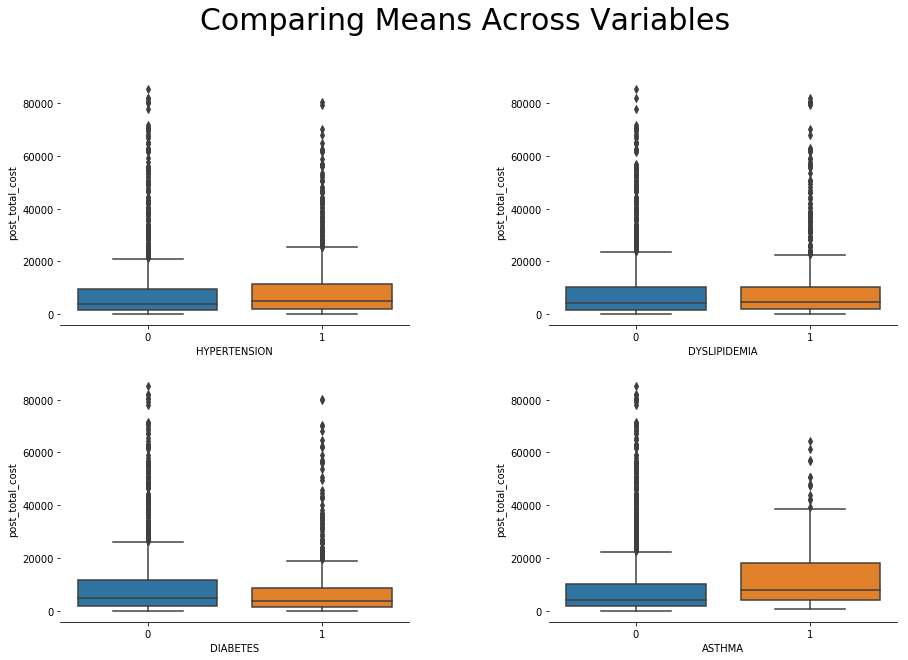

In [33]:
# Setting up the plot sizes and stuff
plt.figure(figsize=(15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
plt.suptitle('Comparing Means Across Variables', fontsize=30)


# Looping over 4 diseases and plotting them in the respective subplots
for dis, i in zip(['HYPERTENSION','DYSLIPIDEMIA', 'DIABETES','ASTHMA'],range(1,5)):
    plt.subplot(2,2,i)
    sns.boxplot(x=dis, y='post_total_cost', data=eda_data)
sns.despine(left=True)

Visually, it looks like HYPERTENSION and DYSLIPIDEMIA may **NOT** be good variables to use to predict post medical cost because we can see that post total cost mean is the same for patients that have HYPERTENSION(1) and DYSLIPIDEMIA(1) and for patients that do not have HYPERTENSION(0) and DYSLIPIDEMIA(0), but we can see there DIABETES & ASTHMA may be a good variables due to a visibly significant differences in the mean. 

In order to solidify this comparision numerically, we will use two sample T Test to see if there truly is a significant difference in the means between the 0's and 1's of the categorical variables in relation to the total medical costs.

In [34]:
"""
This loops over our dataset with all the diagnoses columns and returns back the variables that have a significance level <.05,
showing us that the mean for post total cost for patients that have these diagnoses (1) is significantly different than the 
patients that do not have these diagnoses(0) 

"""
threshold = 0.05

# Empty list to append column names where P-value is less than threshold
cat_columns_chosen = []

# Looping over each categorical variable.
for column in eda_data.iloc[:,0:34]:
    
    # splitting the dataset into 0 or 1.IE: presence of categrical variable of not 
    zero = eda_data[eda_data[column]== 0]['post_total_cost']
    one = eda_data[eda_data[column]== 1]['post_total_cost']
    
    # t-test here
    ttest = stats.ttest_ind(zero , one)
    
    # get p-value 
    if ttest[1] < threshold:
        print('{}: {}'.format(column, round(ttest.pvalue,6) ))
        cat_columns_chosen.append(column)  # Categorical variables to use for predicting the post_total_cost        

ASTHMA: 0.000102
CARDIAC_ARRYTHMIA: 0.000126
CARDIAC_VALVULAR: 0.000766
CHRONIC_KIDNEY: 0.001563
CHRONIC_PAIN_FIBRO: 0.000106
CHF: 1e-06
DEMENTIA: 0.005591
DEPRESSION: 0.0
DIABETES: 9.1e-05
HEPATITIS: 0.032996
LIVER_GALLBLADDER_PANCREAS: 0.003223
MI_CAD: 0.00056
OSTEOARTHRITIS: 0.0
PERIPHERAL_VASCULAR: 0.000494
RENAL_FAILURE: 0.002152
RHEUMATOLOGIC: 0.000738
SLEEP_DISORDERS: 1e-06
SMOKING: 0.012965
THYROID: 0.024687
Solid_Tumor: 0.0
Metastatic: 0.0
Leukemia_Lymphoma: 0.004993
Other_Cancer: 0.011515


## Model Fitting

In [35]:
"""Data Cleaning & Feature Engineering

- **a.** Normalize the continuous variables
- **b.** Deal with outlier data? Cap it maybe
- **c.** Create new features if necessary

##### Normalizing the data

Here we look to employ the use of Guassian normalization techniques to pull our continuous variables, considering that they are not on the same scale
"""

def normalize(cf):
    """takes in a dataframe and normalizes it"""
    scaler = preprocessing.StandardScaler().fit(cf)
    X_scaled = scaler.transform(cf)
    a = pd.DataFrame(X_scaled)
    a.columns = cf.columns
    return a

In [36]:
try:
    # normalizing cont features
    final_reg_scaled = normalize(final_reg)

    # setting index
    final_reg_scaled.index = final_reg.index
    
except ValueError:
    pass
    print ('No continuous feature were selected')

No continuous feature were selected


In [37]:
if len(final_reg.columns) > 0:
    # combining cont + cat features that are selected using the T-test above!
    main_data_reg = pd.concat([final_reg_scaled, reg_categorical_vars[cat_columns_chosen]  ], axis=1)  

else:
    # Only categorical variables from the T-Test
    main_data_reg = reg_categorical_vars[cat_columns_chosen]
    
main_data_reg.head(2)

,ASTHMA,CARDIAC_ARRYTHMIA,CARDIAC_VALVULAR,CHRONIC_KIDNEY,CHRONIC_PAIN_FIBRO,CHF,DEMENTIA,DEPRESSION,DIABETES,HEPATITIS,...,PERIPHERAL_VASCULAR,RENAL_FAILURE,RHEUMATOLOGIC,SLEEP_DISORDERS,SMOKING,THYROID,Solid_Tumor,Metastatic,Leukemia_Lymphoma,Other_Cancer
0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [38]:
# In this section we add in the age and region. T- Tests on multiclass columns were not carried out
add_age_region_precci = reg_categorical_vars[[x for x in reg_categorical_vars.columns if bool(re.search('age|region', x))]].loc[main_data_reg.index]

# appending to the main_data_reg column 
main_data_reg_a = pd.concat([main_data_reg,add_age_region_precci ],1)

In [39]:
# Splitting the dataset into training and validation data
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(main_data_reg_a, data.loc[main_data_reg_a.index]['post_total_cost'], test_size=0.20, random_state=42)

In [40]:
# Using statsmodels.api

    # Creating the data
ols_train_data = pd.concat([X_train_reg,  np.log(y_train_reg) ],1)
all_columns = "+".join([x for x in ols_train_data.columns if x != 'post_total_cost'])
my_formula = "post_total_cost~" + all_columns

    # Fitting the model
mlr_model1 = smf.ols(my_formula, data = ols_train_data).fit()

    # predictions
linear_reg_preds_train = mlr_model1.predict(X_train_reg)
linear_reg_preds_validation = mlr_model1.predict(X_val_reg)


In [41]:
    # Calculating the errors
# In sample RMSE error - LOG
print ( 'In sample RMSE error (log units): ' ,np.sqrt(mean_squared_error(np.log(y_train_reg),linear_reg_preds_train )))

# Outsample error:  testing the validation 
print ('Out sample RMSE error (log units): ' ,np.sqrt(mean_squared_error(np.log(y_val_reg), linear_reg_preds_validation)), '\n')

# In sample RMSE error - LOG
print ( 'In sample RMSE error (In Dollars): ' ,np.sqrt(mean_squared_error((y_train_reg),linear_reg_preds_train)))

# Outsample error:  testing the validation 
print ('Out sample RMSE error (In Dollars): ' ,np.sqrt(mean_squared_error((y_val_reg), linear_reg_preds_validation)))

In sample RMSE error (log units):  1.2910504480412113
Out sample RMSE error (log units):  1.421078470939223 

In sample RMSE error (In Dollars):  16800.05369105279
Out sample RMSE error (In Dollars):  15860.741665789112


In [42]:
# R- Squared metric
r_square_regression_method1 = mlr_model1.rsquared
print ('R- squared metric for this model: {}'.format(r_square_regression_method1))

R- squared metric for this model: 0.18110956363633235


**Interpretaing the errors**

The RMSE or root mean square error allows you to see how much your prediction deviates, on average, from the actual value in the units of the variable

- In sample real RMSE: Average deviation in predicted total_medical_cost for the training dataset is $16800 (hunderds? - CHECK UNITS)

- Out sample real RMSE: Average deviation in predicted total_medical_cost for the validation dataset is $15860 (hunderds? - CHECK UNITS)

In [43]:
# Getting data to analyze LINE assumptions below
residuals = abs(y_train_reg - linear_reg_preds_train)

Conclusion of **Method 1:** In this method we employed the use of correlation analysis to perform feature selection and then use the OLS (Ordinary Least squares Method) to train the model and use it to predict on a validation dataset

## Testing LINE Assumptions

In [44]:
def LINE_test_plot(model, training_data):
    
    """
    Performs a LINE check and returns the relevant plots
    """
    

#     # combining X, Y data to use into 
    ols_train_data = training_data

    model_fitted_y = model.fittedvalues
    
    #model residuals
    model_residuals = model.resid
    
    #normalized residuals
    model_norm_residuals = model.get_influence().resid_studentized_internal
    
    #absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)

    # leverage, from statsmodels internals
    model_leverage = model.get_influence().hat_matrix_diag

    # cook's distance, from statsmodels internals
    model_cooks = model.get_influence().cooks_distance[0]
    
    # Setting up the plot sizes and stuff
    plt.figure(figsize=(15,10))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.suptitle('Checking Linear Regression Assumptions', fontsize=25)

    #-------------------------------------------
    
    #residual plot
    plot_lm_1 = plt.figure(1)
    plot_lm_1.set_figheight(5)
    plot_lm_1.set_figwidth(10)

    plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'post_total_cost', data=ols_train_data, 
                              lowess=True, 
                              scatter_kws={'alpha': 0.5}, 
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')

    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]

    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i, 
                                   xy=(model_fitted_y[i], 
                                       model_residuals[i]));


    #-------------------------------------------
    #QQ plot

    
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

    plot_lm_2.set_figheight(5)
    plot_lm_2.set_figwidth(10)

    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]

    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i, 
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]));

    #---------------------------------------------
    
    plot_lm_3 = plt.figure(3)
    plot_lm_3.set_figheight(5)
    plot_lm_3.set_figwidth(10)

    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i, 
                                   xy=(model_fitted_y[i], 
                                       model_norm_residuals_abs_sqrt[i]));
    
    #-----------------------------------------
    
    plot_lm_4 = plt.figure(4)
    plot_lm_4.set_figheight(5)
    plot_lm_4.set_figwidth(10)

    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
    sns.regplot(model_leverage, model_norm_residuals, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_4.axes[0].set_xlim(0, 0.20)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i, 
                                   xy=(model_leverage[i], 
                                       model_norm_residuals[i]))

    # shenanigans for cook's distance contours
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=1, ls='--', color='red')

    p = len(mlr_model1.params) # number of model parameters

    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50), 
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50)) # 1 line
    plt.legend(loc='upper right');

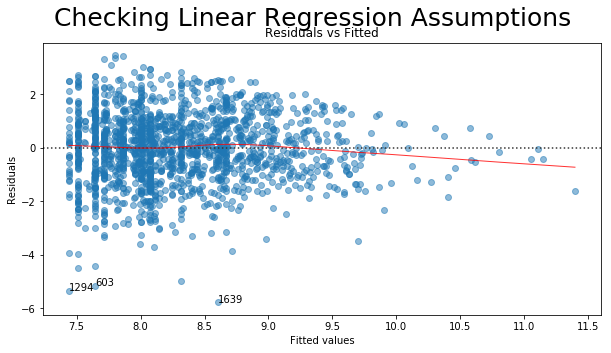

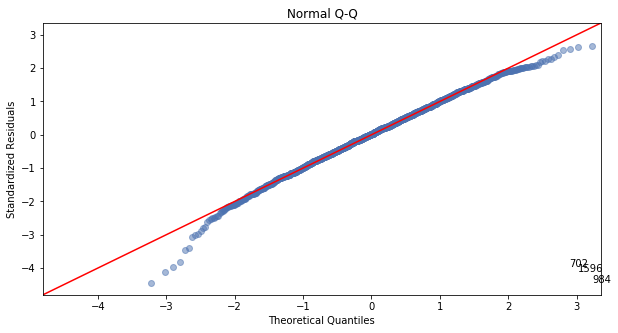

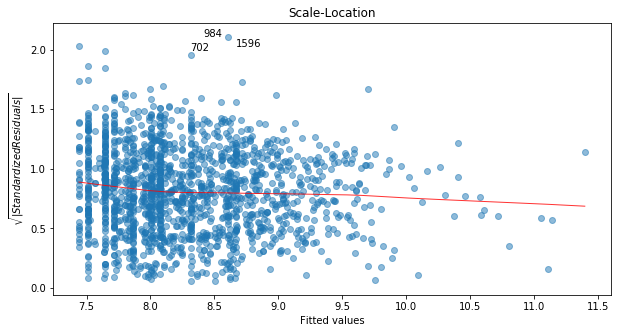

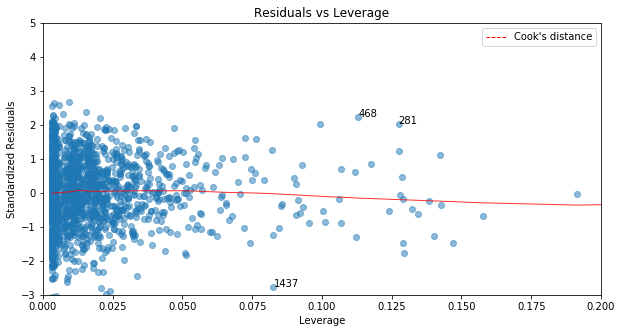

In [45]:
LINE_test_plot(mlr_model1, ols_train_data)

# Regression-  Method 2

- In this section we will employ the use of forward stepwise regression to determine the appropriate features to predict the total_post_cost.

## Feature Selection Using Stepwise Regression

In [60]:
# Normalizing the continouous dataset we have set aside for any regression problem
normalized_reg_cont_vars = normalize(reg_cont_vars)

C:\Users\Darshil Desai\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Darshil Desai\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [61]:
# In this block we will remove all the columns associated with pre_CCI, regionN and age for now
updated_reg_categorical_vars = reg_categorical_vars[reg_categorical_vars.columns[[not i for i in [bool(re.search('pre_CCI_|regionN_|age_grpN_', x)) for x in reg_categorical_vars.columns]]]]                     

In [62]:
# Creating a fresh new dataset for the regression problem. 
stepwise_df_use = pd.concat([normalized_reg_cont_vars ,updated_reg_categorical_vars],1)  # combining the cont and variable features for regression

# Adding the post toal cost coumn in case we want to remove outlier data. Not needed for now
stepwise_df_use_with_cot =  pd.concat([stepwise_df_use, data.loc[stepwise_df_use.index]['post_total_cost']], 1)

# Dropping null columns if any
stepwise_df_use_with_cot = stepwise_df_use_with_cot.dropna()

# # Dropping all rows where post_total_cost is outside of 3 standard deviations. This is one way to deal with outliers
# stepwise_df_use_with_cot = stepwise_df_use_with_cot[((stepwise_df_use_with_cot.post_total_cost - stepwise_df_use_with_cot.post_total_cost.mean()) / stepwise_df_use_with_cot.post_total_cost.std()).abs() < 3]

In [63]:
# Using a package to select columns with p-values less than 0.05
stepwise_columns = stepwise_regression.forward_regression(stepwise_df_use_with_cot[[x for x in stepwise_df_use_with_cot.columns if x != 'post_total_cost']],stepwise_df_use_with_cot.post_total_cost , threshold_in=0.05, verbose=True)

C:\Users\Darshil Desai\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  num_op                         with p-value 2.41436e-38
Add  sexN                           with p-value 5.19528e-163
Add  brand_cost                     with p-value 3.26979e-20
Add  OSTEOARTHRITIS                 with p-value 9.12661e-22
Add  Metastatic                     with p-value 2.06483e-23
Add  pre_op_cost                    with p-value 5.7995e-09
Add  CHF                            with p-value 1.98689e-05
Add  pdc                            with p-value 1.42622e-05
Add  SLEEP_DISORDERS                with p-value 0.000719775
Add  CARDIAC_ARRYTHMIA              with p-value 0.00621775
Add  pre_medical_cost               with p-value 0.00399916
Add  Leukemia_Lymphoma              with p-value 0.00919156
Add  DEMENTIA                       with p-value 0.0108104
Add  PERIPHERAL_VASCULAR            with p-value 0.0201169
Add  DEPRESSION                     with p-value 0.0312768


In [68]:
# Using columns selected from stepwise regression
stepwise_main_data_reg = stepwise_df_use_with_cot[stepwise_columns]

# Adding back all the pre_cci, region and age columns
stepwise_main_data_reg_use = pd.concat([stepwise_main_data_reg, reg_categorical_vars[[x for x in reg_categorical_vars.columns if bool(re.search('age_grpN_|regionN_|pre_CCI_', x))]].loc[stepwise_main_data_reg.index]],1)

# Splitting the dataset into training and validation data
X_train_reg_s, X_val_reg_s, y_train_reg_s, y_val_reg_s = train_test_split(stepwise_main_data_reg_use, data.loc[stepwise_main_data_reg_use.index]['post_total_cost'], test_size=0.20, random_state=42)

## Model Fitting

In [70]:
# Using statsmodels.api

    # Creating the data
ols_train_data_m2 = pd.concat([X_train_reg_s,  np.log(y_train_reg_s) ],1)
all_columns_m2 = "+".join([x for x in ols_train_data_m2.columns if x != 'post_total_cost'])
my_formula_m2 = "post_total_cost~" + all_columns_m2

    # Fitting the model
mlr_model2 = smf.ols(my_formula_m2, data = ols_train_data_m2).fit()

    # predictions
linear_reg_preds_train_m2 = mlr_model2.predict(X_train_reg_s)
linear_reg_preds_validation_m2 = mlr_model2.predict(X_val_reg_s)

    # Calculating the errors
# In sample RMSE error - LOG
print ( 'In sample RMSE error (log units): ' ,np.sqrt(mean_squared_error(np.log(y_train_reg_s),linear_reg_preds_train_m2 )))

# Outsample error:  testing the validation 
print ('Out sample RMSE error (log units): ' ,np.sqrt(mean_squared_error(np.log(y_val_reg_s), linear_reg_preds_validation_m2)), '\n')

# In sample RMSE error - LOG
print ( 'In sample RMSE error (In Dollars): ' ,np.sqrt(mean_squared_error((y_train_reg_s),linear_reg_preds_train_m2)))

# Outsample error:  testing the validation 
print ('Out sample RMSE error (In Dollars): ' ,np.sqrt(mean_squared_error((y_val_reg_s), linear_reg_preds_validation_m2)))

# R- Squared metric
print ('R- squared metric for this model: {}'.format(mlr_model2.rsquared))

In sample RMSE error (log units):  1.2184744782037205
Out sample RMSE error (log units):  1.3566653740059262 

In sample RMSE error (In Dollars):  16799.948985901046
Out sample RMSE error (In Dollars):  15860.688694695915
R- squared metric for this model: 0.27058910211884235


## Testing LINE Assumptions

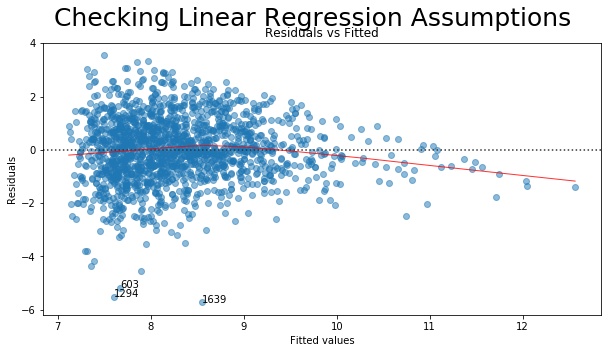

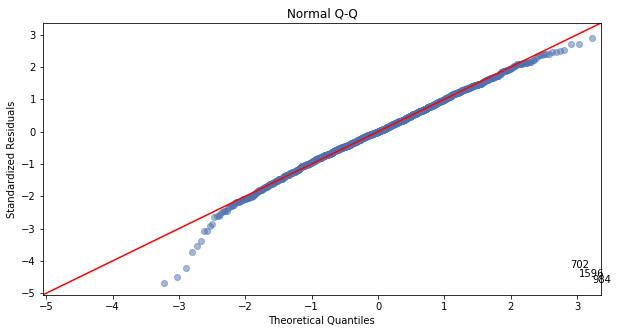

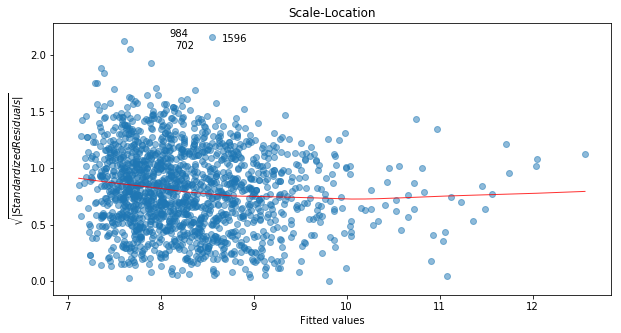

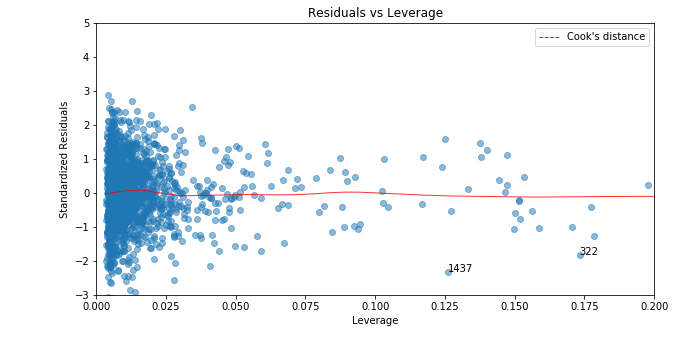

In [71]:
LINE_test_plot(mlr_model2, ols_train_data_m2)

**Conclusion:** Stepwise regression RMSE metrics are not very different from our custom model selection approach in Iteration 1. ADD MORE

# Regression-  Method 3

- Ed add your stuff here!

In [72]:
# EDWIN

CONCLUSION

In [73]:
pd.DataFrame({
    
    # Method 1 ----------------------
    'In Sample Error (Log)': [np.sqrt(mean_squared_error(np.log(y_train_reg),linear_reg_preds_train )),
                             np.sqrt(mean_squared_error(np.log(y_train_reg_s),linear_reg_preds_train_m2 )),
                             'ADD EDWINS METHOD'],
    
    'Out Sample Error (Log)': [np.sqrt(mean_squared_error(np.log(y_val_reg),linear_reg_preds_validation )),
                              np.sqrt(mean_squared_error(np.log(y_val_reg_s),linear_reg_preds_validation_m2 )),
                             'ADD EDWINS METHOD'],
    
    'In Sample Error (Dollar Units)': [np.sqrt(mean_squared_error((y_train_reg),linear_reg_preds_train )),
                                      np.sqrt(mean_squared_error((y_train_reg_s),linear_reg_preds_train_m2 )),
                             'ADD EDWINS METHOD'],
    
    'Out Sample Error (Dollar Units)': [np.sqrt(mean_squared_error((y_val_reg),linear_reg_preds_validation )),
                                       np.sqrt(mean_squared_error((y_val_reg_s),linear_reg_preds_validation_m2 )),
                             'ADD EDWINS METHOD'],
    
    'R-Squared Test': [mlr_model1.rsquared, mlr_model2.rsquared,'ADD EDWINS METHOD']    
    
        
}, index=['Method 1', 'Method 2', 'Method 3']).T

,Method 1,Method 2,Method 3
In Sample Error (Log),1.29105,1.21847,ADD EDWINS METHOD
Out Sample Error (Log),1.42108,1.35667,ADD EDWINS METHOD
In Sample Error (Dollar Units),16800.1,16799.9,ADD EDWINS METHOD
Out Sample Error (Dollar Units),15860.7,15860.7,ADD EDWINS METHOD
R-Squared Test,0.18111,0.270589,ADD EDWINS METHOD


# Classification - Iteration 1

## Feature Selection

This section will focus on determining the which of the appropriate features to incorporate in our model fitting. We will employ the use of various techniques to determine the following: 
    
- **(i.) Which features show significant associativity which the predictor variable we will use for classification. Predicting the pdc_80_flag variable poses as a binary classification problem. 
    - Employ the use of chi-square tests to determine which categorical variables prove to be associative with 
    - Employ the use of the Wilcoxon T-Tests to determine which continuous variables work best in predicting the pdc_80_flag

### Chi - Square tests

In [74]:
"""Co - morbidity index"""
# First we need to make a contigency table 


def chisq(cat_cols, group, a, df):    
    """
    Calculates the chi-square metric for a set of categorical variables given the group
    
    Parameters
    ----------
    : param cat_cols: The column names of categorical columns in from the data file
    : param group: Aither ANTIDIABETIC or ANTICOAGULANT or BOTH as 'ANTIDIABETIC|ANTICOAGULANT'
    : param a: alpha test statistic
    """
    
    data = df
    
    # Only retreiving rows belonging to the group
    subset_ad = data[data['drug_class'].str.contains(group)]
    
    # Initializing empty lists to append into
    var = []
    p_val = []
    

    # Iterating over each cat_column
    for x in cat_cols:
        
        # Contingency table for that categorical column and the pdc_80_flag
        table = np.array(pd.crosstab(subset_ad[x], subset_ad['pdc_80_flag']))

        # Getting statistical metrics
        stat, p, dof, expected = chi2_contingency(table)
        
        # Append all data
        var.append(x), p_val.append(p)
    
    # Empty dataframe to append into
    mod_df = pd.DataFrame({'variable': var, 'p_val': np.round(p_val,6)})

    # return
    return mod_df[mod_df['p_val'] <= a]          


In [75]:
# Only Antidiabetic patients
data1 = data[data['drug_class'].str.contains('ANTIDIABETIC')]

# Remove Age, Region for now
class_categorical_vars_updated = class_categorical_vars[class_categorical_vars.columns[[not i for i in [bool(re.search('pre_CCI_|age_grpN_|regionN_', x)) for x in class_categorical_vars.columns]]]]

# Which categorical columns were chosen for Diabetic patients
cat_chosen = chisq(class_categorical_vars_updated.columns, 'ANTIDIABETIC', 0.05, df=pd.concat([class_categorical_vars_updated, data1[['drug_class', 'pdc_80_flag']]],1)).variable
cat_chosen

11        DIABETES
12    DYSLIPIDEMIA
16    HYPERTENSION
28         THYROID
34            sexN
Name: variable, dtype: object

### Wilcoxon Test

- To choose continous features for classification

In [76]:
# Creating a seperate dataframe with continous features for classification along with drug_class and pdc_80_flag
df_wilcox = pd.concat([class_cont_vars, data1[['drug_class', 'pdc_80_flag']]],1)

# Splitting it into two datasets PDC_80_Flag 0 and 1
df_wilcox_0 = df_wilcox[df_wilcox['pdc_80_flag']==0]
df_wilcox_1 = df_wilcox[df_wilcox['pdc_80_flag']==1]


#Randomly selecting N rows for the Wilcoxon test
np.random.seed(3)
N = 300
df_wilcox_0_r = df_wilcox_0.loc[np.random.choice(df_wilcox_0.index,N)]
df_wilcox_1_r = df_wilcox_1.loc[np.random.choice(df_wilcox_1.index,N)]


# Performing the Wilxocon Test here 

    # Empty list for continous columns to use for classification
cont_cols_use = []

for column, p_value in zip( class_cont_vars.columns, [stats.wilcoxon(df_wilcox_0_r[x],df_wilcox_1_r[x])[1] for x in class_cont_vars.columns]):
    if p_value < 0.05:    
        print ('{}: {}'.format(column, p_value)), cont_cols_use.append(column)                

pdc: 6.060309350527707e-51
pdc_cat: 6.760813950869273e-29
pre_er_cost: 0.02480080595225188
pre_rx_cost: 0.0001248457641211887
num_ndc: 1.5935035583241227e-06
num_gpi6: 0.000483096741248662
log_pre_rx_cost: 8.292802336371263e-07
numofgen: 3.321468002211197e-06
numofbrand: 0.009980112535512039
generic_cost: 3.879276859404366e-08
brand_cost: 0.011234916593773509


## Model Fitting

Prior to model fitting, we will create the combined dataset and then split it up the training dataset into training and validation sets in order to test for hyperparameters

In [77]:
# categorical features for classification
cat_features_classification = class_categorical_vars[cat_chosen]

# cont features fr classification
cont_features_classification = normalize(class_cont_vars[cont_cols_use])
cont_features_classification.index = cat_features_classification.index  # Setting the correct indices again

C:\Users\Darshil Desai\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Darshil Desai\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [78]:
"""Combined dataset using the data created in the block above"""
main_x = pd.concat([cont_features_classification, cat_features_classification], axis=1)
main_x = main_x.dropna()

In [79]:
def return_accu_report(Xval, yval,Xtrain,ytrain, model):
    """
    returns the in and out sample accuracy rates
    """
    preds_log = model.predict(X_val)
    
    # In sample---------------------------
    # Accuracy
    in_sample_accuracy = round(accuracy_score(ytrain ,model.predict(Xtrain)),2) *100
    # Testing
    print ('The in sample accuracy score using this classifier: {} %'.format(in_sample_accuracy))
    
    # Out sample ----------------------
    out_preds = model.predict(Xval)
    
    # Accuracy
    out_sample_accu = round(accuracy_score(yval ,out_preds),2) *100
    # Testing
    print ('The out sample accuracy score using this classifier: {} %'.format(out_sample_accu))

    
    # Confusion matrix for the out sample
    print ('Confusion Matrix: \n' ,confusion_matrix(y_val , out_preds))

In [80]:
# Splitting the dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(main_x, data1.loc[main_x.index]['pdc_80_flag'], test_size=0.10, random_state=41)

### (NB) Classification Using Naive Bayes 

In this section we will employ the use of the Naive Bayes Classifer to predict the pdc_80_flag. Particularily:

- Categorical features used: DIABETES, DYSLIPIDEMIA, HYPERTENSION, THYROID, age_grpN, sexN, regionN
- Continous features used: All for now (will delete later after the statistical section above is filled)

In [81]:
#Create a Gaussian Classifier
nb_model = GaussianNB()

# Fitting the Model
nb_model.fit(X_train,y_train)

return_accu_report(X_val, y_val,X_train,y_train, nb_model)

The in sample accuracy score using this classifier: 100.0 %
The out sample accuracy score using this classifier: 100.0 %
Confusion Matrix: 
 [[56  0]
 [ 0 41]]


### (LR) Logistic Regression

In this section we will employ the use of the Logistic Regression Classifer to predict the pdc_80_flag. Particularily:

- Categorical features used: DIABETES, DYSLIPIDEMIA, HYPERTENSION, THYROID, age_grpN, sexN, regionN
- Continous features used: All for now (will delete later after the statistical section above is filled)

In [82]:
# creating an instance of the model AND fitting it 
log_model = LogisticRegression(random_state=1, penalty="l2", max_iter = 1000, solver = 'lbfgs')

# Fitting the Model
log_model.fit(X_train,y_train)

return_accu_report(X_val, y_val,X_train, y_train, log_model)    

The in sample accuracy score using this classifier: 100.0 %
The out sample accuracy score using this classifier: 100.0 %
Confusion Matrix: 
 [[56  0]
 [ 0 41]]


### (KNN) K - Nearest Neighbors - REMOVE

In this section we will employ the use of the KNN to predict the pdc_80_flag. Particularily:

- Categorical features used: DIABETES, DYSLIPIDEMIA, HYPERTENSION, THYROID, age_grpN, sexN, regionN
- Continous features used: All for now (will delete later after the statistical section above is filled)

In [83]:
# Initializing the model
neigh = KNeighborsClassifier(n_neighbors=3, weights = 'distance')

# fitting the model 
neigh.fit(X_train, y_train)

return_accu_report(X_val, y_val,X_train, y_train, neigh)    

The in sample accuracy score using this classifier: 100.0 %
The out sample accuracy score using this classifier: 97.0 %
Confusion Matrix: 
 [[55  1]
 [ 2 39]]


# Test & Deploy
- For Prof.Zarei

In this section we will facilitate the use of an external dataset (with the same features) to test the models we have created above on new data. 

**PENDING** tomorrow

## Code Archives

In [ ]:
# """Bernoulli ONLY"""

# # Splitting the dataset into training and validation
# X_train_nbt, X_val_nbt, y_train_nbt, y_val_nbt = train_test_split(cat_features_classification, data1.loc[cat_features_classification.index]['pdc_80_flag'] , test_size=0.20, random_state=41)

# nbt1 = BernoulliNB()
# nbt1.fit(X_train_nbt, y_train_nbt)

# # multinomial probabilities
# [x[1] for x in nbt1.predict_proba(X_val_nbt)]


# """Gaussian ONLY"""

# use_cont = cont_features_classification.fillna(0)

# # Splitting the dataset into training and validation
# X_train_nbt1, X_val_nbt1, y_train_nbt1, y_val_nbt1 = train_test_split(use_cont, data1.loc[use_cont.index]['pdc_80_flag'] , test_size=0.20, random_state=41)

# nbt2 = GaussianNB()
# nbt2.fit(X_train_nbt1, y_train_nbt1)

# # Gaussian probabilities
# [x[1] for x in nbt2.predict_proba(X_val_nbt1)]

# sum(y_val_nbt1 == nbt2.predict(X_val_nbt1))/y_val_nbt1.shape[0]


# mult = np.array([x[1] for x in nbt1.predict_proba(X_val_nbt)]) * np.array([x[1] for x in nbt2.predict_proba(X_val_nbt1)])


# len(mult[np.where(mult>0.08)])/mult.shape[0]